In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
from sklearn import preprocessing
from sys import path
path.append(r'E:\data_mining\project\IJCAI-17-口碑\koubei')
import base
import predict

import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取休假表
calenders = base.ReadCalendarCSV();

In [11]:
mean_3_3_3_prediction = pd.read_csv('../data/train/mean/mean_3_3_3_prediction.txt', sep='\t', index_col=0, encoding='UTF-8')

In [12]:
arima_prediction = pd.read_csv('../data/train/arima/arima_prediction.txt', sep='\t', index_col=0, encoding='UTF-8')
arima_prediction = predict.FixFinalPredict(arima_prediction)

In [13]:
blend_prediction = (mean_3_3_3_prediction + arima_prediction) / 2

In [14]:
start = pd.to_datetime('2016-10-18')
end = pd.to_datetime('2016-10-31')
mean_3_3_3_evaluations = {}
arima_evaluations = {}
blend_evaluations = {}

for id in range(1, 2001):
    print(id)
    y_test = base.getTestCount(user_pay_counts, id, start, end)
    mean_3_3_3_evaluations[id] = base.evaluation(y_test, mean_3_3_3_prediction.loc[id].values)
    arima_evaluations[id] = base.evaluation(y_test, arima_prediction.loc[id].values)
    blend_evaluations[id] = base.evaluation(y_test, blend_prediction.loc[id].values)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [15]:
mean_evaluation_df = pd.DataFrame.from_dict(mean_3_3_3_evaluations, orient='index')
arima_evaluation_df = pd.DataFrame.from_dict(arima_evaluations, orient='index')
blend_evaluation_df = pd.DataFrame.from_dict(blend_evaluations, orient='index')

In [16]:
def changeType(t):
    if t == 'mean':
        return 0
#     elif t == 'arima':
#         return 1
#     elif t == 'blend':
#         return 2
    return 1
train_df = pd.concat([mean_evaluation_df, arima_evaluation_df, blend_evaluation_df], axis=1)
train_df.columns = ['mean', 'arima', 'blend']
train_df['type'] = train_df[['mean', 'arima', 'blend']].idxmin(axis=1)

In [17]:
# def changeType(t):
#     if t == 'mean':
#         return 0
#     elif t == 'arima':
#         return 1

# train_df = pd.concat([mean_evaluation_df, arima_evaluation_df], axis=1)
# train_df.columns = ['mean', 'arima']
# train_df['type'] = train_df[['mean', 'arima']].idxmin(axis=1)

In [18]:
# def changeType(t):
#     if t == 'mean':
#         return 0
#     elif t == 'blend':
#         return 1
# train_df = pd.concat([mean_evaluation_df, arima_evaluation_df, blend_evaluation_df], axis=1)
# train_df.columns = ['mean', 'blend']
# train_df['type'] = train_df[['mean', 'blend']].idxmin(axis=1)

In [19]:
train_df['type'] = train_df['type'].apply(changeType)

In [20]:
#diff A-B
def judgePredIntersectType(s):
    #不相交
    if (len(s[s >= 0]) == 14 or len(s[s <= 0]) == 14):
        return 1
    else:
        return 0

In [21]:
intersects = mean_3_3_3_prediction - arima_prediction
intersects = intersects.apply(judgePredIntersectType, axis=1)
train_df['mean_arima_intersect'] = intersects

In [22]:
train_data = pd.read_csv('../data/train/fill_train_data.txt', sep='\t', index_col=0, encoding='UTF-8')
train_data.columns = np.array(range(35))
X_train_data = train_data[np.array(range(21))]

In [23]:
prev_week_data = train_data[np.array(range(14, 21))];

In [24]:
train_df['pre_week_mean'] = prev_week_data.mean(axis=1).astype(np.int)

In [25]:

#diff A-B 
def judgeMeanIntersectType(s):
    #不相交
    if (len(s[s >= 0]) == 14 or len(s[s <= 0]) == 14):
        return 1
    else:
        return 0

In [26]:
intersects = arima_prediction.sub(train_df['pre_week_mean'].squeeze(), axis=0)
train_df['arima_week_distance'] = np.abs(intersects.mean(axis=1))
intersects = intersects.apply(judgeMeanIntersectType, axis=1)
train_df['arima_week_intersect'] = intersects


In [27]:
intersects = mean_3_3_3_prediction.sub(train_df['pre_week_mean'].squeeze(), axis=0)
train_df['mean_week_distance'] = np.abs(intersects.mean(axis=1))
intersects = intersects.apply(judgeMeanIntersectType, axis=1)
train_df['mean_week_intersect'] = intersects

In [28]:
intersects = blend_prediction.sub(train_df['pre_week_mean'].squeeze(), axis=0)
train_df['blend_week_distance'] = np.abs(intersects.mean(axis=1))
intersects = intersects.apply(judgeMeanIntersectType, axis=1)
train_df['blend_week_intersect'] = intersects

In [29]:
# def appendExtrelist(l, count):
#     if len(l) == 0:
#         l.append(count)
#     elif l[len(l) - 1] != count:
#         l.append(count)

# def rebuildMaxlist(maxes):
#     if len(maxes) < 2:
#         return maxes
    
#     threshold = 0.6
#     remove_indexes = []
#     for i in range(1, len(maxes) - 1):
#         if (maxes[i] < maxes[i - 1] * threshold) and (maxes[i] < maxes[i + 1] * threshold):
#             remove_indexes.append(i)
    
#     rebuild_maxes = []
#     for i in range(len(maxes)):
#         if i not in remove_indexes:
#             rebuild_maxes.append(maxes[i])
    
#     return rebuild_maxes

# def rebuildMinlist(mines):
#     if len(mines) < 2:
#         return mines
    
#     threshold = 1.6
#     remove_indexes = []
#     for i in range(1, len(mines) - 1):
#         if (mines[i] > mines[i - 1] * threshold) and (mines[i] > mines[i + 1] * threshold):
#             remove_indexes.append(i)
    
#     rebuild_mins = []
#     for i in range(len(mines)):
#         if i not in remove_indexes:
#             rebuild_mins.append(mines[i])
            
#     return rebuild_mins

# #前14天趋势
# #def 0 持平 1 上升 2 下降
# def getPeriodTrend(id, start_index, end_index, threshold, user_pay_counts, shop_open_dates, calenders):

#     df = X_train_data.loc[id][np.array(range(start_index, end_index))]
#     print(df)
#     maxes = []
#     mins = []
#     current_trend = 0
#     prev_trend = 0;
#     for i in df.index:
#         if i == start_index:
#             continue
        
#         if df[i] > df[i - 1]:
#             current_trend = 1
#         elif df[i] < df[i - 1]:
#             current_trend = 2
#         else:
#             current_trend = 0
                
#         if i == start_index + 1:
#             if current_trend == 1:
#                 appendExtrelist(mins, df[i - 1])
#             elif current_trend == 2:
#                 appendExtrelist(maxes, df[i - 1])
#         elif i == end_index - 1:
#             if current_trend != prev_trend:
#                 if prev_trend == 0:
#                     if current_trend == 1:
#                         appendExtrelist(mins, df[i - 1])
#                     else:
#                         appendExtrelist(maxes, df[i - 1])
#                 elif prev_trend == 1:
#                     appendExtrelist(maxes, df[i - 1])
#                 else:
#                     appendExtrelist(mins, df[i - 1])
                
#             if current_trend == 1:
#                 appendExtrelist(maxes, df[i])
#             elif current_trend == 2:
#                 appendExtrelist(mins, df[i])
#             else:
#                 appendExtrelist(maxes, df[i])
#                 appendExtrelist(mins, df[i])
#         elif current_trend != prev_trend:
#             if prev_trend == 0:
#                 if current_trend == 1:
#                     appendExtrelist(mins, df[i - 1])
#                 else:
#                     appendExtrelist(maxes, df[i - 1])
#             elif prev_trend == 1:
#                 appendExtrelist(maxes, df[i - 1])
#             else:
#                 appendExtrelist(mins, df[i - 1])
        
#         prev_trend = current_trend
    
#     print(maxes)
#     print(mins)
#     maxes = rebuildMaxlist(maxes)
#     mins = rebuildMinlist(mins)
#     max_trend = 0
#     min_trend = 0
#     if len(maxes) == 1:
#         maxes = maxes + maxes
#     elif len(maxes) == 0:
#         maxes = [0, 0] + maxes
    
#     print(maxes)
#     print(mins)
#     if len(mins) == 1:
#         mins = mins + mins
#     elif len(mins) == 0:
#         mins = [0, 0] + mins
    
#     max_mean = np.mean(maxes)
#     min_mean = np.mean(mins)
#     if np.mean(np.diff(maxes)) <= -max_mean * threshold:
#         max_trend = 2
#     elif np.mean(np.diff(maxes)) >= max_mean * threshold:
#         max_trend = 1
#     else:
#         max_trend = 0
        
#     if np.mean(np.diff(mins)) <= -min_mean * threshold:
#         min_trend = 2
#     elif np.mean(np.diff(mins)) >= min_mean * threshold:
#         min_trend = 1
#     else:
#         min_trend = 0
        
#     if max_trend == 0:
#         return min_trend
#     elif max_trend == 1:
#         if min_trend == 2:
#             return 0
#         else:
#             return 1
#     elif max_trend == 2:
#         if min_trend == 1:
#             return 0
#         else:
#             return 2

In [30]:
# def getArimaTrend(id):
#     start_index = 0
#     end_index = 13
#     df = arima_prediction.loc[id]
   
#     print(df)
#     maxes = []
#     mins = []
#     current_trend = 0
#     prev_trend = 0;
#     for i in df.index:
#         i = np.int(i)
#         if i == start_index:
#             continue
        
#         if df[i] > df[i - 1]:
#             current_trend = 1
#         elif df[i] < df[i - 1]:
#             current_trend = 2
#         else:
#             current_trend = 0
                
#         if i == start_index + 1:
#             if current_trend == 1:
#                 appendExtrelist(mins, df[i - 1])
#             elif current_trend == 2:
#                 appendExtrelist(maxes, df[i - 1])
#         elif i == end_index - 1:
#             if current_trend != prev_trend:
#                 if prev_trend == 0:
#                     if current_trend == 1:
#                         appendExtrelist(mins, df[i - 1])
#                     else:
#                         appendExtrelist(maxes, df[i - 1])
#                 elif prev_trend == 1:
#                     appendExtrelist(maxes, df[i - 1])
#                 else:
#                     appendExtrelist(mins, df[i - 1])
                
#             if current_trend == 1:
#                 appendExtrelist(maxes, df[i])
#             elif current_trend == 2:
#                 appendExtrelist(mins, df[i])
#             else:
#                 appendExtrelist(maxes, df[i])
#                 appendExtrelist(mins, df[i])
#         elif current_trend != prev_trend:
#             if prev_trend == 0:
#                 if current_trend == 1:
#                     appendExtrelist(mins, df[i - 1])
#                 else:
#                     appendExtrelist(maxes, df[i - 1])
#             elif prev_trend == 1:
#                 appendExtrelist(maxes, df[i - 1])
#             else:
#                 appendExtrelist(mins, df[i - 1])
        
#         prev_trend = current_trend
    
#     print(maxes)
#     print(mins)
#     maxes = rebuildMaxlist(maxes)
#     mins = rebuildMinlist(mins)
#     max_trend = 0
#     min_trend = 0
#     if len(maxes) == 1:
#         maxes = maxes + maxes
#     elif len(maxes) == 0:
#         maxes = [0, 0] + maxes
    
#     print(maxes)
#     print(mins)
#     if len(mins) == 1:
#         mins = mins + mins
#     elif len(mins) == 0:
#         mins = [0, 0] + mins
    
#     max_mean = np.mean(maxes)
#     min_mean = np.mean(mins)
#     if np.mean(np.diff(maxes)) <= -max_mean * threshold:
#         max_trend = 2
#     elif np.mean(np.diff(maxes)) >= max_mean * threshold:
#         max_trend = 1
#     else:
#         max_trend = 0
        
#     if np.mean(np.diff(mins)) <= -min_mean * threshold:
#         min_trend = 2
#     elif np.mean(np.diff(mins)) >= min_mean * threshold:
#         min_trend = 1
#     else:
#         min_trend = 0
        
#     if max_trend == 0:
#         return min_trend
#     elif max_trend == 1:
#         if min_trend == 2:
#             return 0
#         else:
#             return 1
#     elif max_trend == 2:
#         if min_trend == 1:
#             return 0
#         else:
#             return 2

In [31]:
# arima_trends = []
# threshold = 0.2
# for id in range(1, 2001):
#     print(id)
#     arima_trends.append(getArimaTrend(id))
    #print(getPeriodTrend(id, 7, 21, threshold, user_pay_counts, shop_open_dates, calenders))

In [32]:
# prev_trends = []
# threshold = 0.4
# for id in range(1, 2001):
#     print(id)
#     prev_trends.append(getPeriodTrend(id, 7, 21, threshold, user_pay_counts, shop_open_dates, calenders))
#     #print(getPeriodTrend(id, 7, 21, threshold, user_pay_counts, shop_open_dates, calenders))

In [33]:
# train_df['prev_trend'] = prev_trends
# train_df['arima_trend'] = arima_trends

In [34]:
train_df['mean_mean'] = mean_3_3_3_prediction.mean(axis=1)
train_df['arima_mean'] = arima_prediction.mean(axis=1)
train_df['blend_mean'] = blend_prediction.mean(axis=1)

In [35]:
periiodicity_df = pd.read_csv("../data/train/common/periodicity_v2.txt", sep="\t", encoding='UTF-8', index_col=0)

In [174]:
rule_predictions = []
a = 0
for id in range(1, 2001):
    if ((periiodicity_df.loc[id]['mean_deviate'] > 0.50) and (periiodicity_df.loc[id]['mean_gap'] < 0.57)):
        rule_predictions.append(train_df['blend'][id])
        a = a + 1
    else:
        rule_predictions.append(train_df['mean'][id])
np.mean(rule_predictions)

0.082532465949642961

In [175]:
a

128

In [182]:
X_train_df = pd.DataFrame()
# X_train_df['max'] = X_train_data.max(axis=1)
# X_train_df['min'] = X_train_data.min(axis=1)
# X_train_df['std'] = X_train_data.std(axis=1)
# X_train_df['var'] = X_train_data.var(axis=1)
# X_train_df['mean'] = X_train_data.mean(axis=1)
# X_train_df['median'] = X_train_data.median(axis=1)

In [183]:
# X_train_df['mean_max'] = mean_3_3_3_prediction.max(axis=1)
# X_train_df['mean_min'] = mean_3_3_3_prediction.min(axis=1)
#X_train_df['mean_std'] = mean_3_3_3_prediction.std(axis=1)
# X_train_df['mean_var'] = mean_3_3_3_prediction.var(axis=1)
X_train_df['mean_mean'] = mean_3_3_3_prediction.mean(axis=1)
# X_train_df['mean_median'] = mean_3_3_3_prediction.median(axis=1)
# X_train_df['arima_max'] = arima_prediction.max(axis=1)
# X_train_df['arima_min'] = arima_prediction.min(axis=1)
#X_train_df['arima_std'] = arima_prediction.std(axis=1)
# X_train_df['arima_var'] = arima_prediction.var(axis=1)
X_train_df['arima_mean'] = arima_prediction.mean(axis=1)
# X_train_df['arima_median'] = arima_prediction.median(axis=1)

X_train_df['blend_mean'] = blend_prediction.mean(axis=1)

X_train_df['prev_week_mean'] = train_df['pre_week_mean']

train_df['mean_mean_arima'] = train_df['mean_mean'] - train_df['arima_mean']

In [184]:
X_train_df['daytype_mean_std'] = periiodicity_df['mean_std']
X_train_df['daytype_std_1'] = periiodicity_df['std_1']
X_train_df['daytype_std_2'] = periiodicity_df['std_2']
X_train_df['daytype_std_3'] = periiodicity_df['std_3']
X_train_df['daytype_std_5'] = periiodicity_df['std_5']

#std_mean	deviate_1	deviate_2	deviate_3	deviate_5	mean_deviate
X_train_df['std_mean'] = periiodicity_df['std_mean']
X_train_df['deviate_1'] = periiodicity_df['deviate_1']
X_train_df['deviate_2'] = periiodicity_df['deviate_2']
X_train_df['deviate_3'] = periiodicity_df['deviate_3']
X_train_df['deviate_5'] = periiodicity_df['deviate_5']


X_train_df['trend_0'] = periiodicity_df['trend_0']
X_train_df['trend_1'] = periiodicity_df['trend_1']
X_train_df['trend_2'] = periiodicity_df['trend_2']
X_train_df['trend_3'] = periiodicity_df['trend_3']
X_train_df['trend_4'] = periiodicity_df['trend_4']
X_train_df['trend_5'] = periiodicity_df['trend_5']
X_train_df['trend_6'] = periiodicity_df['trend_6']
X_train_df['smooth'] = periiodicity_df['smooth']

X_train_df['mean_deviate'] = periiodicity_df['mean_deviate']
X_train_df['mean_gap'] = periiodicity_df['mean_gap']

In [185]:
X_train_df['diff_arima_max'] = arima_prediction.max(axis=1) - prev_week_data.max(axis=1)
X_train_df['diff_arima_min'] = arima_prediction.min(axis=1) - prev_week_data.min(axis=1)
X_train_df['diff_arima_std'] = arima_prediction.std(axis=1) - prev_week_data.std(axis=1)
X_train_df['diff_arima_var'] = arima_prediction.var(axis=1)- prev_week_data.var(axis=1)
X_train_df['diff_arima_mean'] = arima_prediction.mean(axis=1) - prev_week_data.mean(axis=1)
X_train_df['diff_arima_median'] = arima_prediction.median(axis=1) - prev_week_data.median(axis=1)

X_train_df['diff_mean_max'] = mean_3_3_3_prediction.max(axis=1) - prev_week_data.max(axis=1)
X_train_df['diff_mean_min'] = mean_3_3_3_prediction.min(axis=1) - prev_week_data.min(axis=1)
X_train_df['diff_mean_std'] = mean_3_3_3_prediction.std(axis=1) - prev_week_data.std(axis=1)
X_train_df['diff_mean_var'] = mean_3_3_3_prediction.var(axis=1) - prev_week_data.var(axis=1)
X_train_df['diff_mean_mean'] = mean_3_3_3_prediction.mean(axis=1) - prev_week_data.mean(axis=1)
X_train_df['diff_mean_median'] = mean_3_3_3_prediction.median(axis=1) - prev_week_data.median(axis=1)

X_train_df['diff_blend_max'] = blend_prediction.max(axis=1) - prev_week_data.max(axis=1)
X_train_df['diff_blend_min'] = blend_prediction.min(axis=1) - prev_week_data.min(axis=1)
X_train_df['diff_blend_std'] = blend_prediction.std(axis=1) - prev_week_data.std(axis=1)
X_train_df['diff_blend_var'] = blend_prediction.var(axis=1) - prev_week_data.var(axis=1)
X_train_df['diff_blend_mean'] = np.abs(blend_prediction.mean(axis=1) - prev_week_data.mean(axis=1))
X_train_df['diff_blend_median'] = blend_prediction.median(axis=1) - prev_week_data.median(axis=1)

X_train_df['diff_mean_arima_max'] = mean_3_3_3_prediction.max(axis=1) - arima_prediction.max(axis=1)
X_train_df['diff_mean_arima_min'] = mean_3_3_3_prediction.min(axis=1) - arima_prediction.min(axis=1)
X_train_df['diff_mean_arima_std'] = mean_3_3_3_prediction.std(axis=1) - arima_prediction.std(axis=1)
X_train_df['diff_mean_arima_var'] = mean_3_3_3_prediction.var(axis=1) - arima_prediction.var(axis=1)
X_train_df['diff_mean_arima_mean'] = mean_3_3_3_prediction.mean(axis=1) - arima_prediction.mean(axis=1)
X_train_df['diff_mean_arima_median'] = mean_3_3_3_prediction.median(axis=1) - arima_prediction.median(axis=1)

X_train_df['diff_blend_mean_max'] = blend_prediction.max(axis=1) - mean_3_3_3_prediction.max(axis=1)
X_train_df['diff_blend_mean_min'] = blend_prediction.min(axis=1) - mean_3_3_3_prediction.min(axis=1)
X_train_df['diff_blend_mean_std'] = blend_prediction.std(axis=1) - mean_3_3_3_prediction.std(axis=1)
X_train_df['diff_blend_mean_var'] = blend_prediction.var(axis=1) - mean_3_3_3_prediction.var(axis=1)
X_train_df['diff_blend_mean_mean'] = np.abs(blend_prediction.mean(axis=1) - mean_3_3_3_prediction.mean(axis=1))
X_train_df['diff_blend_mean_median'] = blend_prediction.median(axis=1) - mean_3_3_3_prediction.median(axis=1)

X_train_df['diff_blend_arima_max'] = blend_prediction.max(axis=1) - arima_prediction.max(axis=1)
X_train_df['diff_blend_arima_min'] = blend_prediction.min(axis=1) - arima_prediction.min(axis=1)
X_train_df['diff_blend_arima_std'] = blend_prediction.std(axis=1) - arima_prediction.std(axis=1)
X_train_df['diff_blend_arima_var'] = blend_prediction.var(axis=1) - arima_prediction.var(axis=1)
X_train_df['diff_blend_arima_mean'] = np.abs(blend_prediction.mean(axis=1) - arima_prediction.mean(axis=1))
X_train_df['diff_blend_arima_median'] = blend_prediction.median(axis=1) - arima_prediction.median(axis=1)



In [186]:
X_train_df['mean_week_distance'] = train_df['mean_week_distance']
X_train_df['arima_week_distance'] = train_df['arima_week_distance']
X_train_df['blend_week_distance'] = train_df['blend_week_distance']

train_df['week_mean_arima_distance'] = train_df['mean_week_distance'] - train_df['arima_week_distance']

In [187]:
X_train_df['week_mean_arima_distance'] = train_df['week_mean_arima_distance']


In [188]:
X_train_scaled = preprocessing.scale(X_train_df.values)
X_train_df = pd.DataFrame(X_train_scaled)
X_train_df = X_train_df.set_index(np.array(range(1, 2001)))
X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['arima_week_intersect'], prefix='arima_week_intersect').astype(np.int), left_index=True, right_index=True)
X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['mean_week_intersect'], prefix='mean_week_intersect').astype(np.int), left_index=True, right_index=True)
X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['blend_week_intersect'], prefix='blend_week_intersect').astype(np.int), left_index=True, right_index=True)

X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['mean_arima_intersect'], prefix='mean_arima_intersect').astype(np.int), left_index=True, right_index=True)

#X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['min_distance'], prefix='min_distance').astype(np.int), left_index=True, right_index=True)

#X_train_df = pd.merge(X_train_df,  pd.get_dummies(train_df['prev_trend'], prefix='prev_trend').astype(np.int), left_index=True, right_index=True)

In [189]:
X_train_df['week_mean_arima_distance_type'] = train_df['week_mean_arima_distance'].apply(lambda x: 0 if x < 0 else 1)

In [190]:
y_train_df = train_df['type']
y_train_df = y_train_df.to_frame()

In [191]:
y_train_df['type'].value_counts()

0    1358
1     642
Name: type, dtype: int64

In [192]:
today = datetime.date.today()

In [193]:
X_train_df.to_csv('../data/train/classify_3/X_train.csv')

In [194]:
y_train_df.to_csv('../data/train/classify_3/y_train.csv')

In [37]:
#X_train_df

In [36]:
plot_count_data = pd.read_csv('../data/train/fill_train_data.txt', sep='\t', index_col=0, encoding='UTF-8')

In [37]:
plot_count_data.columns = plot_count_data.columns.map(lambda str_date:datetime.datetime.strptime(str_date, "%Y-%m-%d"))

In [38]:
aa = plot_count_data.loc[3].to_frame()
aa = aa.rename(columns={3:'count'})

In [39]:
aa['holiday'] = calenders.loc[aa.index.strftime('%Y-%m-%d')]['daytype'].values

In [62]:
def plotShopPayCounts(shop_id, date_range, predicts, names, evaluations, predict_num):
    #counts = base.countShopPayTimePeriods(user_pay_counts, shop_id, date_range, [datetime.timedelta(hours=0), datetime.timedelta(hours=23)])
    #counts = base.WipeInvalidUserPayCount(counts)
    counts = plot_count_data.loc[shop_id].to_frame()
    counts.columns = ['count']

    counts['holiday'] = calenders.loc[counts.index.strftime('%Y-%m-%d')]['daytype'].values
    info = shop_infos.ix[shop_id]
    weathers = base.readWeatherData(city_names.loc[info['city']])
    counts['weather'] = weathers.loc[counts.index]['desc'].values

    counts = counts.reset_index(drop=True)
    
    train_index = np.array(range(len(counts.index)))
    predict_index = np.array(range(len(counts.index)- predict_num, len(counts.index)))
    mean_index = np.array(range(len(counts.index)- 7 - predict_num, len(counts.index) - predict_num))
    f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(train_index, counts['count'].values)
    
#     temp = counts[counts['holiday'] == 1]
#     ax.scatter(temp.index, temp['count'], color='r')
#     temp = counts[counts['holiday'] == 2]
#     ax.scatter(temp.index, temp['count'], color='g')
#     temp = counts[counts['holiday'] == 3]
#     ax.scatter(temp.index, temp['count'], color='b')
#     temp = counts[counts['holiday'] == 4]
#     ax.scatter(temp.index, temp['count'], color='k')
#     temp = counts[counts['holiday'] == 5]
#     ax.scatter(temp.index, temp['count'], color='y')
    
    for i, name in enumerate(names):
        ax.plot(predict_index, predicts[i].loc[id], label=name)
        print("%s : %f"%(name, evaluations[i][id]))
    
#     ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)
    
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    mean_value = np.int(train_data.loc[id][np.array(range(14, 21))].mean())
    print('pre_week_mean_value=' + str(mean_value))
    ax.axhline(y=mean_value, linewidth=1, color='r')
    plt.legend()
    plt.show()

In [46]:
train_data.loc[428][np.array(range(14, 21))]

14    139
15    120
16    136
17    145
18    160
19    127
20    159
Name: 428, dtype: int64

In [42]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')
# ax.bar(positive_train_df['type'], positive_train_df['mean_mean_intersect'], positive_train_df['pred_intersect'], zdir='y', color='b', alpha=0.8)
# ax.bar(negative_train_df['mean_arima_intersect'], negative_train_df['mean_mean_intersect'], negative_train_df['pred_intersect'], zdir='y', color='r', alpha=0.8)

# ax.set_xlabel('mean_arima')
# ax.set_ylabel('mean_mean')
# ax.set_zlabel('pred')

# plt.show()

In [43]:
periiodicity_df['type'] = y_train_df['type']

NameError: name 'y_train_df' is not defined

In [47]:
mean_train_df = periiodicity_df[periiodicity_df['type'] == 0]
arima_train_df = periiodicity_df[periiodicity_df['type'] == 1]
blend_train_df = periiodicity_df[periiodicity_df['type'] == 2]


KeyError: 'type'

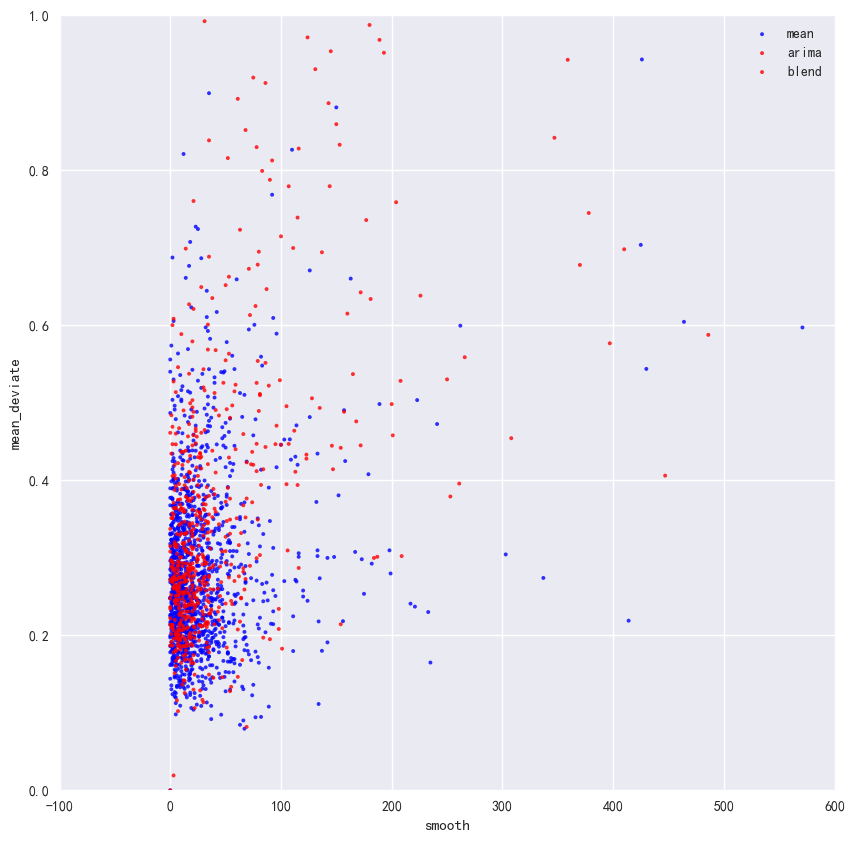

In [172]:
f, (ax) = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(mean_train_df['smooth'], mean_train_df['mean_deviate'] ,color='blue',s=8,edgecolor='none', alpha = 0.8, label='mean')
ax.scatter(arima_train_df['smooth'], arima_train_df['mean_deviate'] ,color='r',s=8,edgecolor='none', alpha = 0.8, label='arima')
ax.scatter(blend_train_df['smooth'], blend_train_df['mean_deviate'] ,color='r',s=8,edgecolor='none', alpha = 0.8, label='blend')
plt.ylim(0,1)
ax.set_xlabel('smooth')
ax.set_ylabel('mean_deviate')
plt.legend()
plt.show()

In [53]:
train_df['week_mean_arima'] = train_df['mean_week_distance'] - train_df['arima_week_distance']

In [54]:
train_df['mean_mean_arima'] = train_df['mean_mean'] - train_df['arima_mean']

In [55]:
intersect_df = train_df[(train_df['mean_arima_intersect'] == 1) & (train_df['mean_week_intersect'] == 0)& (train_df['arima_week_intersect'] == 1)]

In [56]:
intersect_df['type'].value_counts()

0    99
1    45
Name: type, dtype: int64

In [57]:
all_intersect_df = intersect_df[intersect_df['type'] == 1]

In [58]:
all_intersect_df['type'].value_counts()

1    45
Name: type, dtype: int64

In [237]:
intersect_df[['week_mean_arima', 'type', 'mean_mean_arima', 'arima_trend', 'prev_trend']]

,week_mean_arima,type,mean_mean_arima,arima_trend,prev_trend
41,-62.785714,0,62.785714,0,0
62,-15.857143,0,-17.285714,0,0
67,3.285714,1,23.857143,0,0
105,-29.000000,0,29.000000,0,0
171,-2.142857,0,19.285714,0,0
204,-5.214286,1,-10.357143,0,0
278,-49.357143,0,66.500000,0,0
313,-101.000000,0,-101.000000,0,2
456,7.642857,0,10.928571,0,0
464,-18.142857,1,26.428571,0,0


In [187]:
intersect_df = train_df[(train_df['mean_arima_intersect'] == 0) & train_df['arima_week_intersect'] == 1]

In [188]:
intersect_df['type'].value_counts()

0    476
1    231
Name: type, dtype: int64

In [164]:
intersect_df[intersect_df['type'] == 0]

mean                     184
arima                    184
blend                    184
type                     184
mean_arima_intersect     184
arima_blend_intersect    184
blend_mean_intersect     184
pre_week_mean            184
arima_week_distance      184
arima_week_intersect     184
mean_week_distance       184
mean_week_intersect      184
blend_week_distance      184
blend_week_intersect     184
prev_trend               184
dtype: int64

In [158]:
train_df['type'].value_counts()

0    1358
2     417
1     225
Name: type, dtype: int64

In [156]:
plot_df = periiodicity_df

In [157]:
plot_df['mean_gap'] = plot_df['mean_gap'].astype(np.int)
plot_df['std_mean'] = plot_df['std_mean'].astype(np.int)

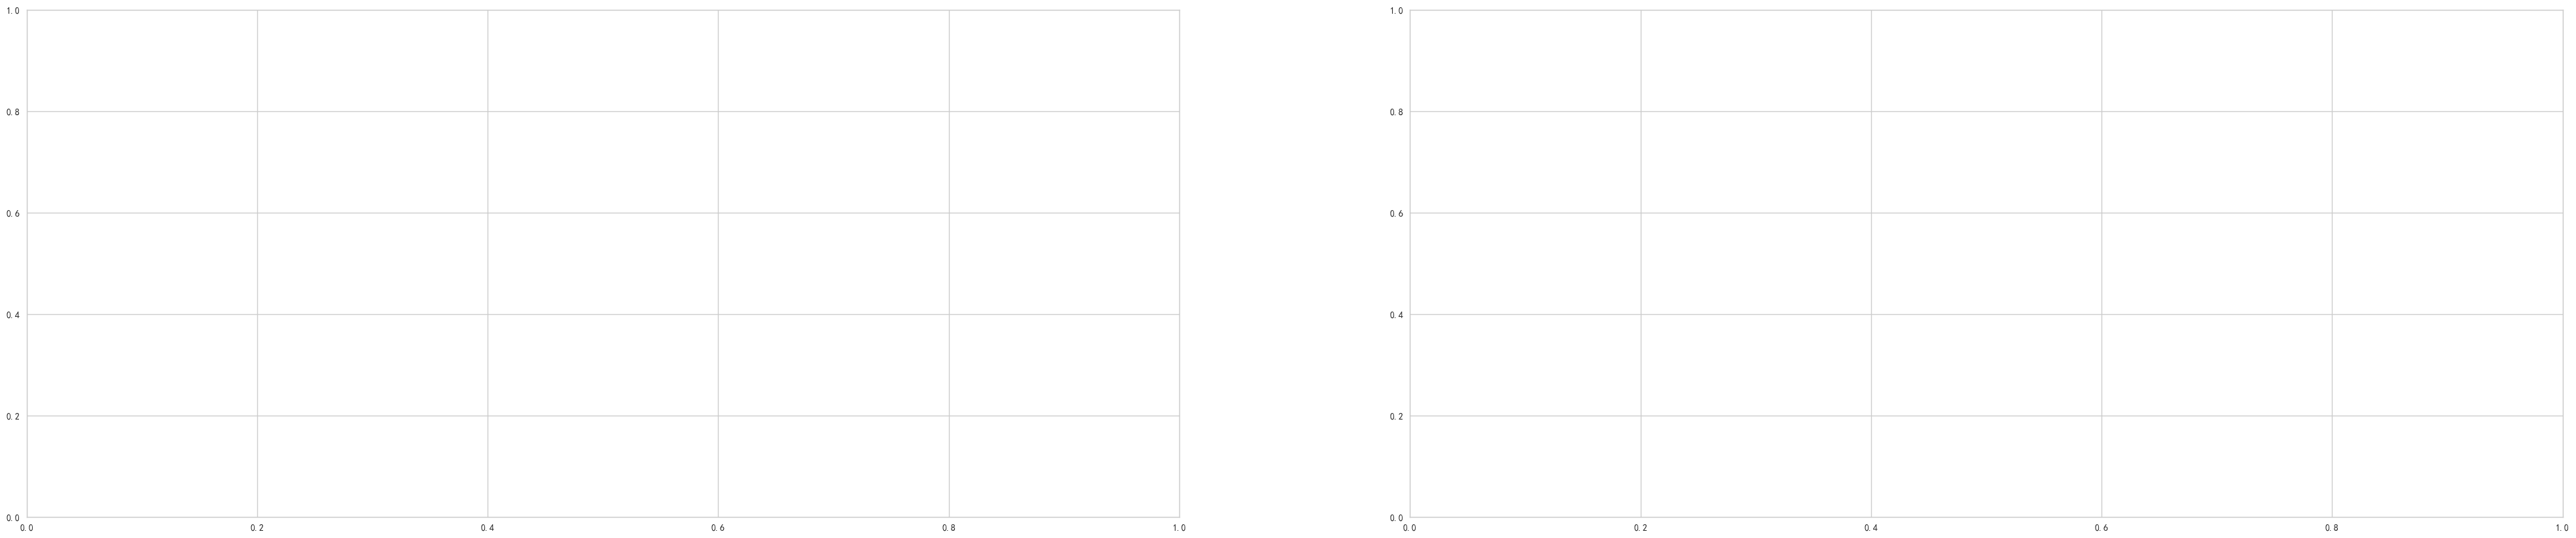

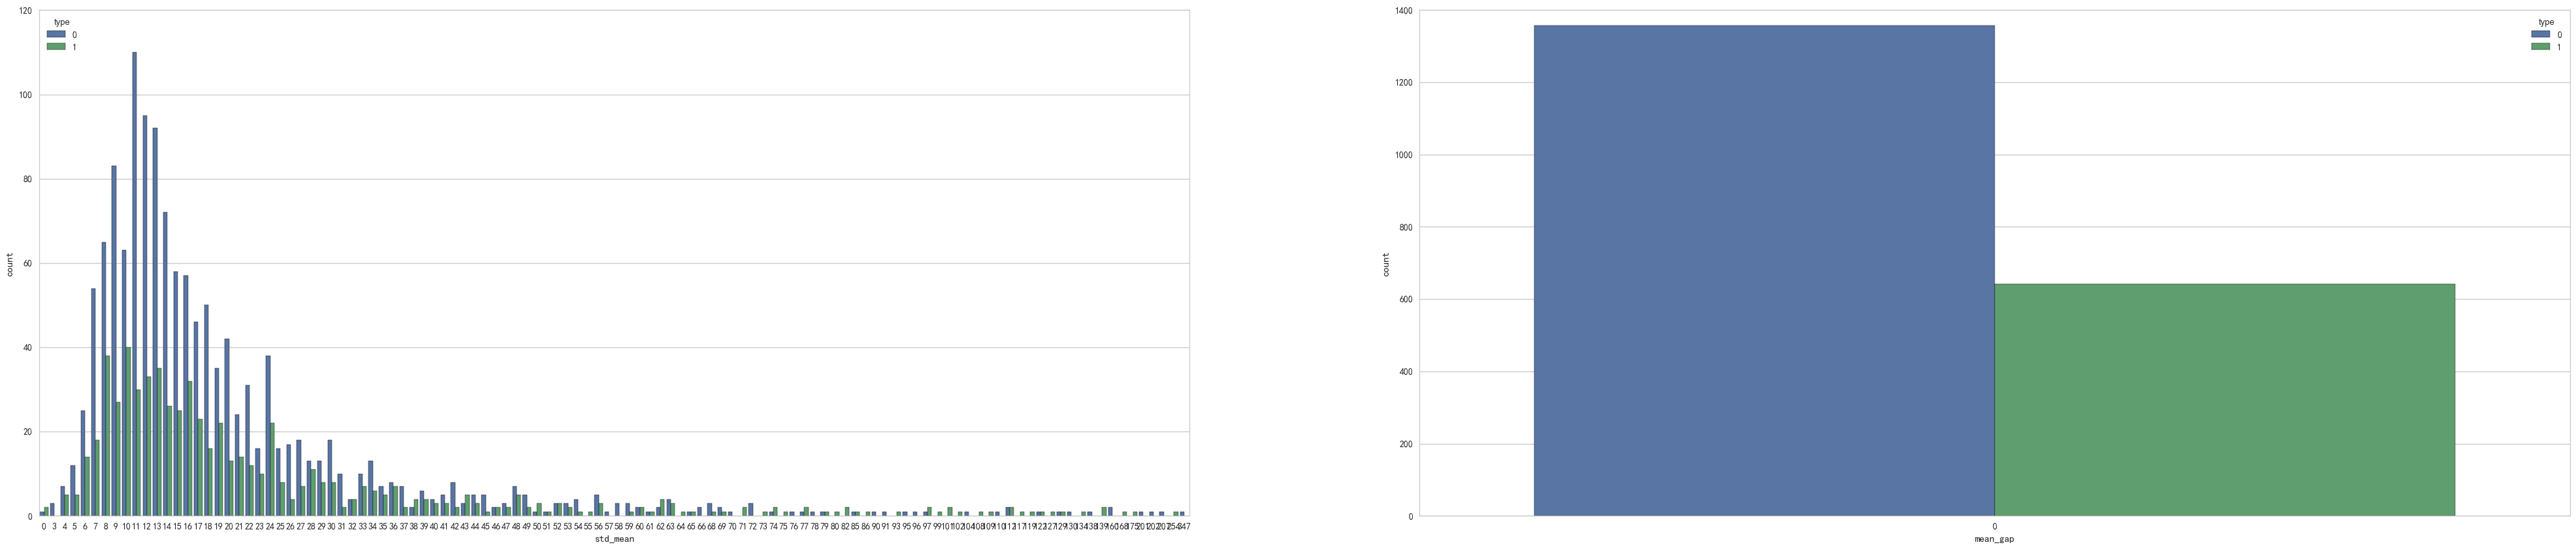

In [158]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 10))

sns.set(style="whitegrid")

sns.countplot(x='std_mean', hue="type", data=plot_df, ax=ax1)
sns.countplot(x='mean_gap', hue="type", data=plot_df, ax=ax2)
plt.show()

In [284]:
diff_evaluations = mean_evaluation_df - blend_evaluation_df

In [285]:
sort_diff_evaluations = diff_evaluations.sort_values(0)

In [49]:
evaluations = [mean_3_3_3_evaluations, arima_evaluations, blend_evaluations]

In [50]:
predicts = [mean_3_3_3_prediction, arima_prediction, blend_prediction]
names = ['3_3_3', 'arima','blend']

In [51]:
#i=1900
406 1897 428 1136 1550 507 334 1762 10 1788 454 1799 1272 1529 794 1725 55 319 569 906 1688 938 954 603 316 1400 1333 769 97 1842	1
1185 158 1585 1789 1478 1323 964 465 1818 1701 1808 939 1554 501 1308 1904 1713 1800 473

SyntaxError: invalid syntax (<ipython-input-51-1e454108ab50>, line 2)

In [52]:
extra_mean_df = intersect_df[intersect_df['type'] == 0]

NameError: name 'intersect_df' is not defined

In [53]:
not_mean_pred_df = y_pred_df[y_pred_df['0'] == 1]

NameError: name 'y_pred_df' is not defined

In [54]:
not_mean_pred_df.count()

NameError: name 'not_mean_pred_df' is not defined

In [55]:
positive_df = y_train_df[y_train_df['type'] == 1]

NameError: name 'y_train_df' is not defined

In [56]:
positive_df.count()

NameError: name 'positive_df' is not defined

In [57]:
i

NameError: name 'i' is not defined

In [58]:
i  = 0

1914
deviate：0.558854
gap：0.334990
3_3_3 : 0.256329
arima : 0.101870
blend : 0.187257
pre_week_mean_value=167


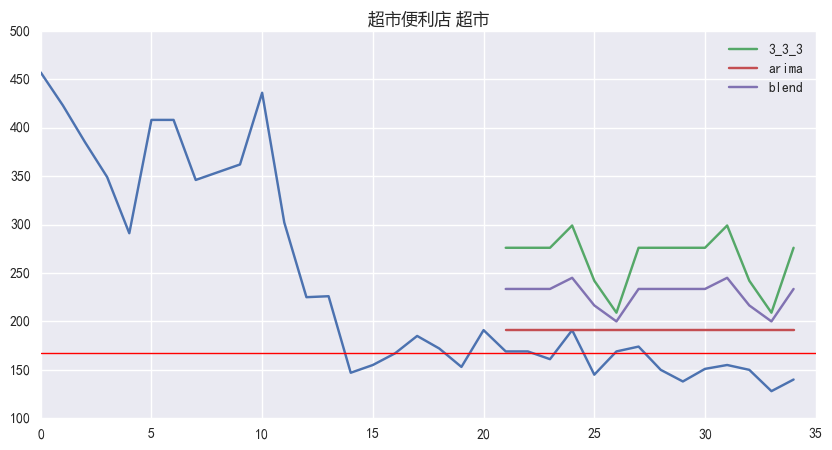

In [67]:
id = 1914
#id = positive_df.index[i]
#i = i + 1
#id = 657
print(id)
#open_time = shop_open_dates.loc[id]['date'];
open_time = pd.to_datetime('2016-8-13')
start_time = open_time;
end_time = pd.to_datetime('2016-10-31')

print("deviate：%f"%periiodicity_df.loc[id]['mean_deviate'])
print('gap：%f'%periiodicity_df.loc[id]['mean_gap'])
#print('trend:%d'%(train_df['prev_trend'][id]))
#print('predict:%d'%(y_pred_df[id]))
plotShopPayCounts(id, [start_time, end_time], predicts, names, evaluations, 14)


In [82]:
diff_evaluation = mean_evaluation_df - blend_evaluation_df

In [103]:
mean_evaluation_data_df.columns = ['mean', 'evaluation']

In [104]:
mean_evaluation_data_df.to_csv('../data/compare/mean_evaluation.csv')

In [136]:
filter_prediction_df = pd.DataFrame(filter_prediction)

In [137]:
filter_prediction_df = filter_prediction_df.T

In [ ]:
min_evaluations = 

In [156]:
# X_train_df['last_max'] = X_train_data.max(axis=1) == X_train_data[20]
# X_train_df['last_min'] = X_train_data.min(axis=1) == X_train_data[20]
# X_train_df[['last_max', 'last_min']] = X_train_df[['last_max', 'last_min']].applymap(lambda x : 1 if x == True else 0)

In [206]:
y_pred_df = pd.read_csv('../data/train/classify_3/y_predict_rf.csv', index_col=0, encoding='UTF-8')

In [207]:
combine_evaluations = {}
sub_mean_evaluations = {}
for id in y_pred_df.index:
    if y_pred_df.loc[id].values == 0:
        combine_evaluations[id] = train_df['mean'][id];
    elif y_pred_df.loc[id].values == 1:
        combine_evaluations[id] = train_df['blend'][id]
    elif y_pred_df.loc[id].values == 2:
        combine_evaluations[id] = train_df['blend'][id]
        
    sub_mean_evaluations[id] = train_df['mean'][id];
combine_evaluation_df = pd.DataFrame.from_dict(combine_evaluations, orient='index')
sub_mean_evaluation_df = pd.DataFrame.from_dict(sub_mean_evaluations, orient='index')

In [208]:
combine_evaluation_df.mean()

0    0.08373
dtype: float64

In [205]:
sub_mean_evaluation_df.mean()

0    0.085953
dtype: float64